In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

In [2]:
#Creating toy dataset and splitting it into train & test parts
x, y = make_classification(n_samples = 10000, n_features = 2, n_informative = 2, n_redundant = 0, n_clusters_per_class = 1, random_state = 60)
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify = y, random_state = 62)

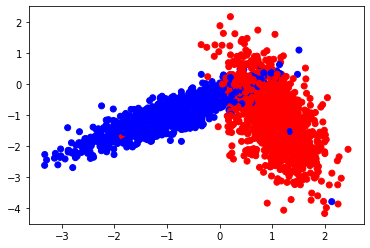

In [3]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
plt.show()

In [4]:
def RandomSearchCV(x_train, y_train, classifier, param_range, folds):
    '''
    This function randomly selects k in the given range and computes the accuracies on the train & test data
    '''
    
    trainscores = []
    testscores = []
    (a, b) = param_range
    params = random.sample(range(a, b), 10) #Randomly generates 10 unique numbers in the given range (a, b)
    group_size = len(x_train) / folds   #group_size holds the number of data points that each group contains,i.e,
    #the size of a group.
    for k in tqdm(params):    # To iterate through 10 unique random numbers
        trainscores_folds = []
        testscores_folds = []
        
        x_test_temp = []
        y_test_temp = []
        x_train_temp = []
        y_train_temp = []
        
        #The strategy of splitting data into train and test is, suppose folds = n then the data points in the 
        #x_train is divided into n equal parts(groups) for each value of k, and to do the division we run a loop 
        #from 0 to (n - 1) and in each iteration of the loop the cross validation data is that group of data 
        #whose group number is equal to the value of i, where i is in the range(0, n).
        
        for i in range(0, folds):
            for j in range(0, len(x_train)):
                if j >= i * group_size and j < i * group_size + group_size:  #This splits the data into train
                    #and test groups.
                    x_test_temp.append(x_train[j])
                    y_test_temp.append(y_train[j])
                else:
                    x_train_temp.append(x_train[j])
                    y_train_temp.append(y_train[j])
            
            X_train = np.array(x_train_temp)
            Y_train = np.array(y_train_temp)
            X_test = np.array(x_test_temp)
            Y_test = np.array(y_test_temp)
            
            classifier.n_neighbors = k
            classifier.fit(X_train, Y_train)
            
            Y_predicted = classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_test, Y_predicted))
            
            Y_predicted = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    return trainscores, testscores,params

In [5]:
def TheBest_k(params, trainscores, testscores):
    '''
    This function determines the best hyperparameter given the lists of hyperparameters, trainscores and testscores
    '''
    #The best hyperparameter is the parameter for which (trainscore[i] - testscores[i]) is minimum
    min_gap = trainscores[0] - testscores[0]
    k = params[0]
    for i in range(1, len(params)):
        gap = trainscores[i] - testscores[i]
        if  gap < min_gap:
            min_gap = gap
            k = params[i]
    return k

100%|██████████| 10/10 [01:32<00:00,  9.08s/it]


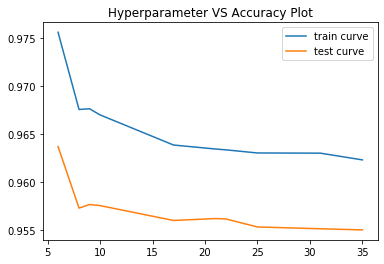

The best k is 22


In [6]:
neigh = KNeighborsClassifier()
param_range = (1, 40)
folds = 5
trainscores, testscores, params = RandomSearchCV(X_train, y_train, neigh, param_range, folds)
new_trainscores = []
new_testscores = []
sorted_params = sorted(params)

for i in range(0, len(sorted_params)):
    idx = params.index(sorted_params[i])
    new_trainscores.append(trainscores[idx])
    new_testscores.append(testscores[idx])
    
plt.plot(sorted_params, new_trainscores, label = 'train curve')
plt.plot(sorted_params, new_testscores, label = 'test curve')
plt.title('Hyperparameter VS Accuracy Plot')
plt.legend()
plt.show()

k = TheBest_k(sorted_params, new_trainscores, new_testscores)
print('The best k is %i' %k)

In [9]:
#The code for this function is somewhat similar to the code which has been given to the reference notebook.
#I did not copy and paste it directly.First I have understood the code, after that I have written it myself.
def PlotDecisionBoundary(x1, x2, y, clf):
    '''
    This function plots the decision boundary for the given k-NN classifier 
    '''
    colors1 = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    colors2 = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    x_min, x_max = x1.min() - 1, x1.max() + 1
    y_min, y_max = x2.min() - 1, x2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, z, cmap = colors1) #plots the decision boundary
    plt.scatter(x1, x2, c = y, cmap = colors2) #plots the training points
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title('Classification with %i-NN' %clf.n_neighbors)
    plt.show()

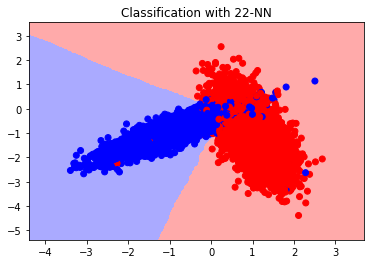

In [10]:
neigh = KNeighborsClassifier(n_neighbors = k)
neigh.fit(X_train, y_train)
PlotDecisionBoundary(X_train[:, 0], X_train[:, 1], y_train, neigh)